In [1]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square,create_rectangle, CellType
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym, grad, inner)

In [2]:
mesh = create_rectangle(MPI.COMM_WORLD, [[0.,0.], [3.,1.]],[50,20], CellType.triangle)
t = 0
T = 10
num_steps = 500
dt = T / num_steps

In [3]:
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

In [4]:
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

In [5]:
# functions to set dirichlet boundary conditions and inflow p
def walls(x):
    return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1))

def inflow(x):
    return np.isclose(x[0], 0)

def outflow(x):
    return np.isclose(x[0], 3)

In [6]:
%matplotlib inline
wall_dofs = locate_dofs_geometrical(V, walls)
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bc_noslip = dirichletbc(u_noslip, wall_dofs, V)

In [7]:
inflow_dofs = locate_dofs_geometrical(Q, inflow)
bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q)

In [8]:
outflow_dofs = locate_dofs_geometrical(Q, outflow)
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]

In [9]:
%matplotlib inline
u_n = Function(V)
u_n.name = "u_n"
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0, 0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

In [10]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

#a1 = form([[inner(grad(u), grad(v)) * dx, inner(p, div(v)) * dx], [inner(div(u), q) * dx, None]])
#L1 = form([inner(f, v) * dx, inner(Constant(mesh, PETSc.ScalarType(0)), q) * dx])  # type: ignore
# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx

In [11]:
a1 = form(lhs(F1))
L1 = form(rhs(F1))

In [12]:
A1 = assemble_matrix(a1, bcs=bcu) # type: ignore
A1.assemble()
b1 = create_vector(L1)

In [13]:
# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

In [14]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

In [15]:
from pathlib import Path
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t)

In [16]:
def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4 * x[1] * (1.0 - x[1])
    return values


u_ex = Function(V)
u_ex.interpolate(u_exact)

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

In [17]:
for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_.vector)
    u_.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.vector.array - u_ex.vector.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
# Close xmdf file
vtx_u.close()
vtx_p.close()
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

Time 0.02, L2-error 1.18e+00, Max error 5.33e-02
Time 0.42, L2-error 8.50e-01, Max error 2.37e-05
Time 0.82, L2-error 8.43e-01, Max error 1.62e-05
Time 1.22, L2-error 8.43e-01, Max error 1.33e-05
Time 1.62, L2-error 8.43e-01, Max error 1.27e-05
Time 2.02, L2-error 8.43e-01, Max error 1.11e-05
Time 2.42, L2-error 8.43e-01, Max error 9.28e-06
Time 2.82, L2-error 8.43e-01, Max error 7.60e-06
Time 3.22, L2-error 8.43e-01, Max error 6.15e-06
Time 3.62, L2-error 8.43e-01, Max error 4.94e-06
Time 4.02, L2-error 8.43e-01, Max error 3.94e-06
Time 4.42, L2-error 8.43e-01, Max error 3.85e-06
Time 4.82, L2-error 8.43e-01, Max error 3.90e-06
Time 5.22, L2-error 8.43e-01, Max error 3.94e-06
Time 5.62, L2-error 8.43e-01, Max error 3.97e-06
Time 6.02, L2-error 8.43e-01, Max error 4.00e-06
Time 6.42, L2-error 8.43e-01, Max error 4.03e-06
Time 6.82, L2-error 8.43e-01, Max error 4.06e-06
Time 7.22, L2-error 8.43e-01, Max error 4.09e-06
Time 7.62, L2-error 8.43e-01, Max error 4.11e-06
Time 8.02, L2-error 

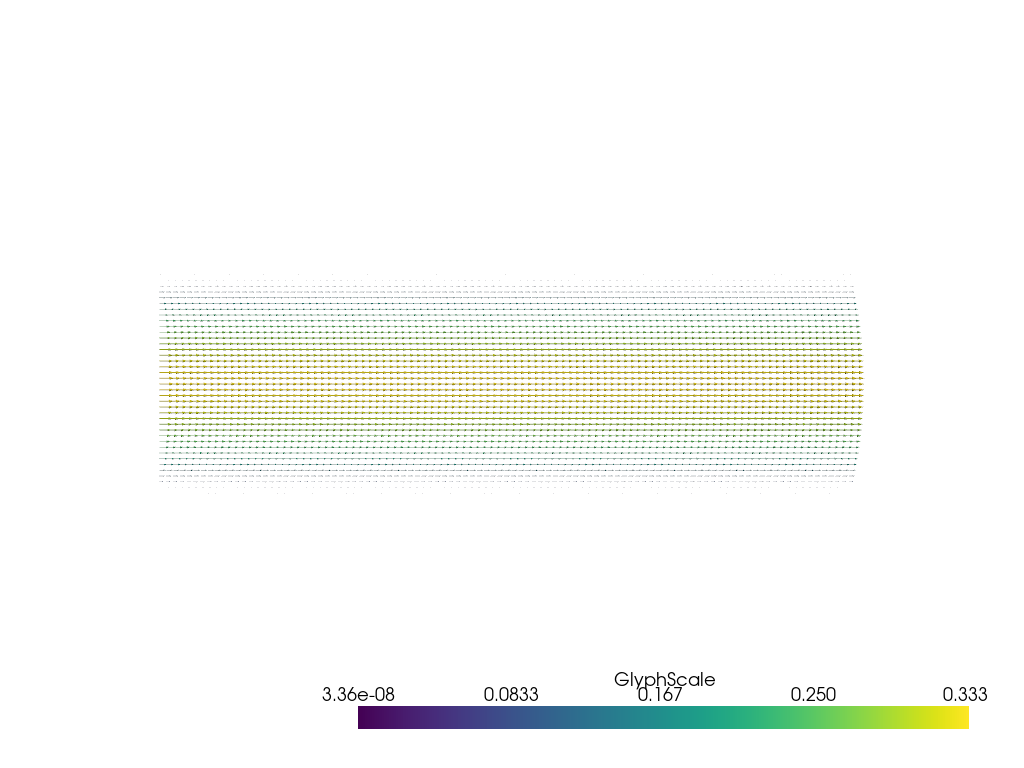

In [18]:
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
#mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
#grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
#plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs2.png")